# Optional Lab - Simple Neural Network
In this lab we will build a small neural network using Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)


## DataSet

In [20]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 
让我们绘制下面的咖啡烘焙数据。这两个特征是摄氏温度和烘烤持续时间（以分钟为单位）。在家烘焙咖啡建议将烘焙持续时间保持在12至15分钟之间，而温度应保持在175至260摄氏度之间。当然，随着温度升高，烘烤持续时间应缩短。

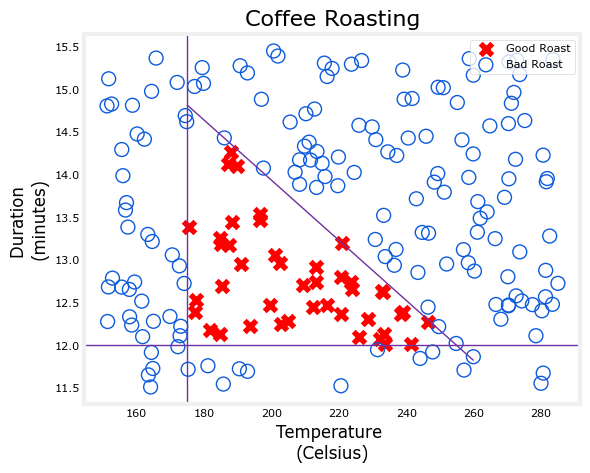

In [21]:
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.
### 数据标准化
如果对数据进行标准化（反向传播，将在下周的课程中介绍）以适应数据，将会更快地进行。这与您在第1门课程中使用的相同程序，其中数据中的特征都被标准化以具有类似的范围。

下面的过程使用了Keras的[标准化层](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)，包括以下步骤：
- 创建一个“标准化层”。请注意，如此应用时，这不是模型中的一层。
- '适应'数据。这会学习数据集的均值和方差，并在内部保存这些值。
- 对数据进行标准化。
重要的是，对任何将使用学习的模型的未来数据应用标准化。

In [22]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [23]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   

(200000, 2) (200000, 1)


## Tensorflow Model

### Model
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

In [24]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` provides a description of the network:
**注释 1：** `tf.keras.Input(shape=(2,))` 指定了输入的期望形状。这允许Tensorflow在这一点上确定权重和偏差参数的大小。这在探索Tensorflow模型时非常有用。在实践中，这个语句可以省略，Tensorflow会在指定输入数据时自动确定网络参数的大小。

**注释 2：** 在最后一层包含Sigmoid激活函数并不被认为是最佳实践。相反，它可以考虑在损失函数中，从而提高数值稳定性。这将在后面的实验中更详细地描述。

`model.summary()` 提供了网络的描述：

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.
摘要中显示的参数计数对应于下面显示的权重和偏差数组中的元素数量。

In [26]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases Tensorflow has instantiated.  The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.
让我们来检查TensorFlow实例化的权重和偏差。权重 $W$ 的大小应该是（输入特征的数量，层中的神经元数量），而偏差 $b$ 的大小应该与层中的神经元数量相匹配：

- 在具有3个神经元的第一层中，我们期望 $W$ 的大小是（2,3），$b$ 应该有3个元素。

- 在具有1个神经元的第二层中，我们期望 $W$ 的大小是（3,1），$b$ 应该有1个元素。

这与您提供的神经网络模型的结构相吻合，因为第一层有3个神经元，第二层有1个神经元，且输入层具有2个特征。所以，根据上述说明，权重和偏差的大小应该符合您的期望。

In [27]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.97 -0.3   0.08]
 [ 0.62 -1.02  0.24]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.38]
 [ 0.97]
 [-0.13]] 
b2(1,): [0.]


The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [28]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)


Epoch 1/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.2978
Epoch 2/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1391
Epoch 3/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1299
Epoch 4/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1239
Epoch 5/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1170
Epoch 6/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1113
Epoch 7/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.1065
Epoch 8/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0284
Epoch 9/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.0126
Epoch 10/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0086


#### Updated Weights
After fitting, the weights have been updated: 

In [29]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[  0.23 -17.47  -9.39]
 [ -8.01 -14.6   -0.15]] 
b1: [-10.15  -2.31 -10.3 ]
W2:
 [[-27.8 ]
 [ 23.81]
 [-32.38]] 
b2: [-7.7]


接下来，我们将加载之前训练运行保存的权重。这是为了确保这个笔记本在随着时间的推移发生的Tensorflow更改时仍然稳定。不同的训练运行可能会产生略有不同的结果，下面的讨论适用于特定的解决方案。如果希望查看不加载之前保存权重的情况，可以将这个单元格注释掉并重新运行笔记本。

In [30]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [31]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 90ms/step
predictions = 
 [[9.63e-01]
 [3.03e-08]]


#### Epochs and batches
In the `compile` statement above, the number of `epochs` was set to 10. This specifies that the entire data set should be applied during training 10 times.  During training, you see output describing the progress of training that looks like this:
```
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
The first line, `Epoch 1/10`, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Tensorflow is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line `6250/6250 [====` is describing which batch has been executed.
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782


To convert the probabilities to a decision, we apply a threshold:
为了将概率转化为决策，我们应用一个阈值：

In [32]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [33]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.
> Note: In labs we typically number things starting at zero while the lectures may start with 1.
## 层函数
让我们检查单元的功能，以确定它们在咖啡烘烤决策中的作用。我们将绘制每个节点对所有输入值（持续时间，温度）的输出。每个单元都是一个逻辑函数，其输出范围可以从零到一。图中的阴影表示输出值。
> 注意：在实验中，通常从零开始对事物进行编号，而在讲座中可能从1开始。

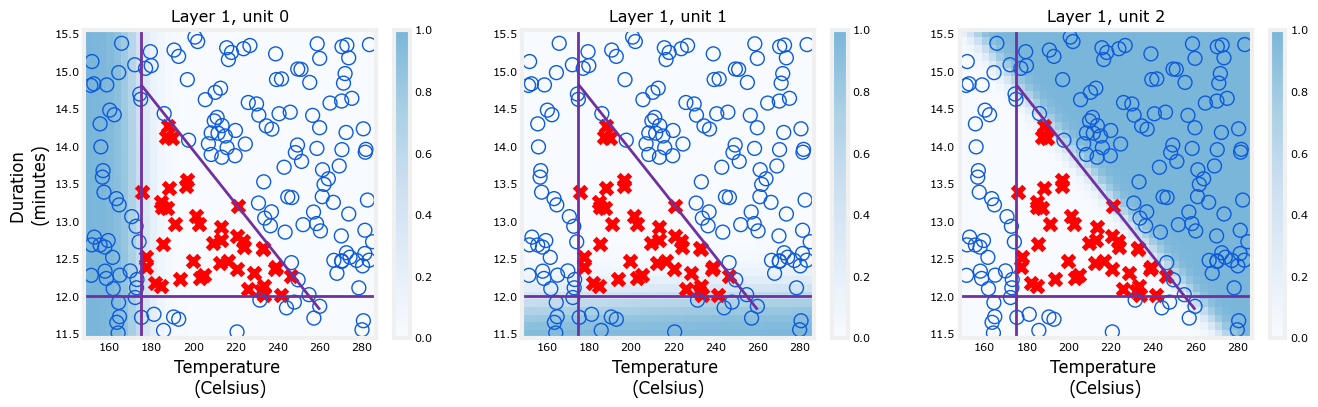

In [34]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.
阴影显示了每个单元负责不同的“糟糕烘焙”区域。单元0在温度太低时具有较大的值。单元1在持续时间太短时具有较大的值，而单元2在时间/温度的组合不佳时具有较大的值。值得注意的是，这个神经网络通过梯度下降的过程自行学习了这些函数。它们与人们可能选择来做出相同决策的函数非常相似。

The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.
最终层的函数图形有点难以可视化。它的输入是第一层的输出。我们知道第一层使用Sigmoid函数，因此它们的输出范围在0和1之间。我们可以创建一个三维图，计算所有可能的三个输入组合的输出。如下所示。在上面，高输出值对应于“糟糕烘焙”的区域。在下面，最大输出位于三个输入都很小的区域，对应于“良好烘焙”的区域。

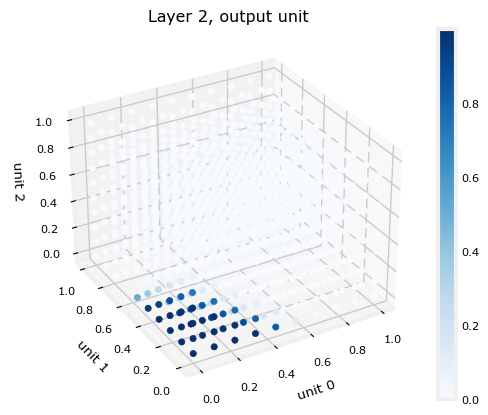

In [35]:
plt_output_unit(W2,b2)

The final graph shows the whole network in action.  
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.   
The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.  
The following takes a moment to run
最终的图展示了整个网络的运作。
左侧的图是由蓝色阴影表示的最终层的原始输出。这与用X和O表示的训练数据叠加在一起。
右侧的图是在经过决策阈值处理后的网络输出。这里的X和O对应于网络所做出的决策。
以下代码可能需要一些时间来运行。

7/7 [==============================] - 0s 1ms/step


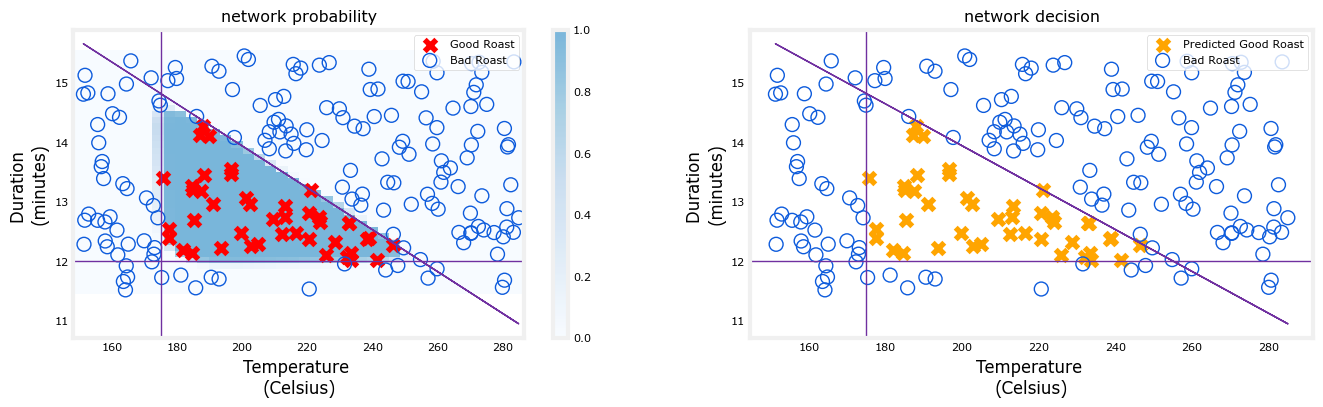

In [36]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in Tensorflow. 
The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.